In [1]:
!pip install tensorflow==1.15.2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 128, 64, 4, len(characters)

ABCDEFGHIJKLMNOPQRSTUVWXYZ


In [3]:
!pip install pillow

<PIL.Image.Image image mode=RGB size=128x64 at 0x7F9A5C22C278>


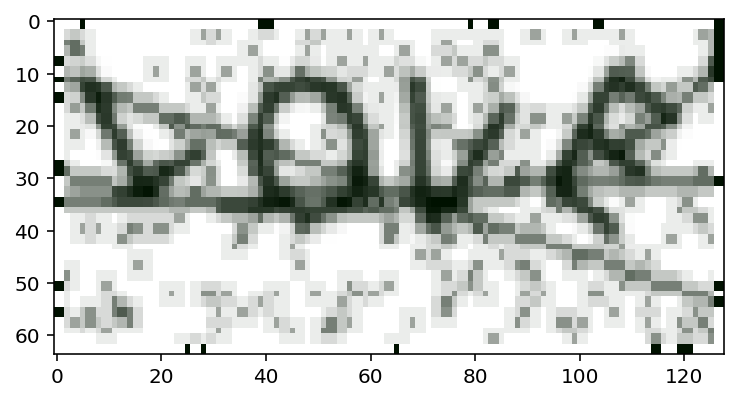

In [4]:
import random
import tempfile
import os
import subprocess
import six
try:
    from cStringIO import StringIO
except ImportError:
    from io import BytesIO as StringIO
import json

import PIL
from PIL import ImageDraw, ImageFont

DISTANCE_FROM_TOP = 4

def getsize(font, text):
    if hasattr(font, "getoffset"):
        return tuple([x + y for x, y in zip(font.getsize(text), font.getoffset(text))])
    else:
        return font.getsize(text)

def makeimg(size):
    image = PIL.Image.new("RGB", size, '#ffffff')
    return image

def _callable_from_string(string_or_callable):
    if callable(string_or_callable):
        return string_or_callable
    else:
        return getattr(__import__('.'.join(string_or_callable.split('.')[:-1]), {}, {}, ['']), string_or_callable.split('.')[-1])

def noise_dots(draw, image):
    size = image.size
    for p in range(int(size[0] * size[1] * 0.1)):
        draw.point(
            (random.randint(0, size[0]), random.randint(0, size[1])),
            fill='#001100',
        )
    return draw

def noise_arcs(draw, image):
    size = image.size
    draw.arc([-20, -20, size[0], 20], 0, 295, fill='#001100')
    draw.line(
        [-20, 20, size[0] + 20, size[1] - 20], fill='#001100'
    )
    draw.line([-20, 0, size[0] + 20, size[1]], fill='#001100')
    return draw

def noise_functions():
    return map(_callable_from_string, ('noise_arcs', 'noise_dots',))

def post_smooth(image):
    from PIL import ImageFilter

    return image.filter(ImageFilter.SMOOTH)

def filter_functions():
    return map(_callable_from_string, ('post_smooth',))


def captcha_image(text, scale=1):
    fontpath = "Vera.ttf"

    if fontpath.lower().strip().endswith("ttf"):
        font = ImageFont.truetype(fontpath, 22 * scale)
    else:
        font = ImageFont.load(fontpath)

    size = getsize(font, text)
    size = (size[0] * 2, int(size[1] * 1.4))

    image = makeimg(size)
    xpos = 2

    charlist = []
    for char in text:
        if char in '''_"',.;:-''' and len(charlist) >= 1:
            charlist[-1] += char
        else:
            charlist.append(char)
    for char in charlist:
        fgimage = PIL.Image.new("RGB", size, '#001100')
        charimage = PIL.Image.new("L", getsize(font, " %s " % char), "#000000")
        chardraw = PIL.ImageDraw.Draw(charimage)
        chardraw.text((0, 0), " %s " % char, font=font, fill="#ffffff")
        if (-35, 35):
            charimage = charimage.rotate(
                random.randrange(*(-35, 35)),
                expand=0,
                resample=PIL.Image.BICUBIC,
            )
        charimage = charimage.crop(charimage.getbbox())
        maskimage = PIL.Image.new("L", size)

        maskimage.paste(
            charimage,
            (
                xpos,
                DISTANCE_FROM_TOP,
                xpos + charimage.size[0],
                DISTANCE_FROM_TOP + charimage.size[1],
            ),
        )
        size = maskimage.size
        image = PIL.Image.composite(fgimage, image, maskimage)
        xpos = xpos + 2 + charimage.size[0]


    image = image.crop((0, 0, xpos + 1, size[1]))
    draw = ImageDraw.Draw(image)

    for f in [noise_dots, noise_arcs]:
        draw = f(draw, image)
    for f in [post_smooth]:
        image = f(image)


    return image.resize((128,64))

if __name__ == "__main__":
    img = captcha_image("LOVE")
    plt.imshow(np.array(img))
    print(img)

In [5]:
import tensorflow as tf
import tensorflow.keras.backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)
tf.__version__

'1.14.0'

In [6]:
from tensorflow.keras.utils import Sequence

class CaptchaSequence(Sequence):
    def __init__(self, characters, batch_size, steps, n_len=4, width=128, height=64):
        self.characters = characters
        self.batch_size = batch_size
        self.steps = steps
        self.n_len = n_len
        self.width = width
        self.height = height
        self.n_class = len(characters)
    
    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        y = [np.zeros((self.batch_size, self.n_class), dtype=np.uint8) for i in range(self.n_len)]
        for i in range(self.batch_size):
            random_str = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            X[i] = np.array(captcha_image(random_str)) / 255.0
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, self.characters.find(ch)] = 1
        return X, y

Text(0.5, 1.0, 'NVQO')

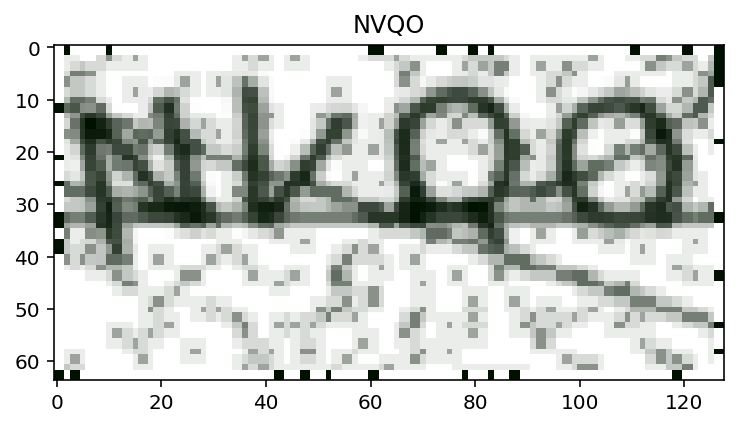

In [7]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

data = CaptchaSequence(characters, batch_size=1, steps=1)
X, y = data[0]
plt.imshow(X[0])
plt.title(decode(y))

In [20]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(inputs=input_tensor, outputs=x)

<tf.Tensor 'input_3:0' shape=(?, 64, 128, 3) dtype=float32>

In [9]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='cnn.png', show_shapes=True)
Image('cnn.png')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 128, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 128, 32)  128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 128, 32)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *

train_data = CaptchaSequence(characters, batch_size=128, steps=1000)
valid_data = CaptchaSequence(characters, batch_size=128, steps=100)
callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv'), ModelCheckpoint('cnn_best.h5', save_best_only=True)]

"""
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-3, amsgrad=True), 
              metrics=['accuracy'])
model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,
                    callbacks=callbacks)
"""

"\nmodel.compile(loss='categorical_crossentropy',\n              optimizer=Adam(1e-3, amsgrad=True), \n              metrics=['accuracy'])\nmodel.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,\n                    callbacks=callbacks)\n"

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *
model.load_weights('cnn_best.h5')

train_data = CaptchaSequence(characters, batch_size=128, steps=1000)
valid_data = CaptchaSequence(characters, batch_size=128, steps=100)
callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv', append=True), 
             ModelCheckpoint('cnn_best.h5', save_best_only=True)]
"""
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-4, amsgrad=True), 
              metrics=['accuracy'])
model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,
                    callbacks=callbacks)
"""

"\nmodel.compile(loss='categorical_crossentropy',\n              optimizer=Adam(1e-4, amsgrad=True), \n              metrics=['accuracy'])\nmodel.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,\n                    callbacks=callbacks)\n"

In [ ]:
model.save('gdrive/My Drive/cnn_best.h5')

In [ ]:
model.load_weights('gdrive/My Drive/cnn_best.h5')

In [24]:
model.input.dtype

tf.float32

(1, 64, 128, 3)


(-0.5, 127.5, 63.5, -0.5)

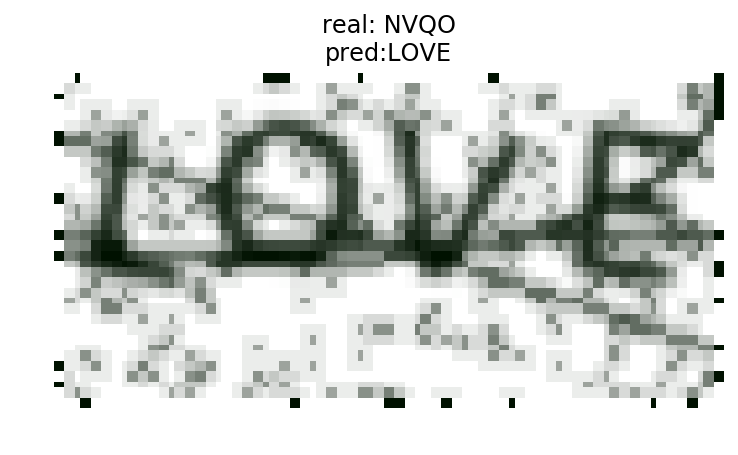

In [14]:
X = PIL.Image.open("love.png").resize((128,64))
X =  np.array(X).reshape((1, 64, 128, 3)) / 255.0
y_pred = model.predict(X)
print(X.shape)
#f = open("shape.txt", "w")
#f.write(str(X))
#f.close()
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

In [19]:
!python -c 'import tqdm'

In [15]:
def evaluate(model, batch_num=100):
    batch_acc = 0
    for X, y in CaptchaSequence(characters, batch_size=128, steps=100):
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=-1).T
        y_true = np.argmax(y, axis=-1).T
        batch_acc += (y_true == y_pred).all(axis=-1).mean()
    return batch_acc / batch_num

print(evaluate(model))

0.996875


In [34]:
!pip install --upgrade tensorflow

     |██████████████████████          | 290.6 MB 139.9 MB/s eta 0:00:01    |█████████                       | 118.9 MB 99.2 MB/s eta 0:00:04     |█████████████▉                  | 182.3 MB 99.2 MB/s eta 0:00:03

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 421.8 MB 20 kB/s /s eta 0:00:01
  Using cached tensorflow_estimator-2.1.0-py2.py3-none-any.whl (448 kB)
  Using cached tensorboard-2.1.1-py3-none-any.whl (3.8 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 1.15.2
    Uninstalling tensorflow-1.15.2:
      Successfully uninstalled tensorflow-1.15.2


In [55]:
outputs = tf.convert_to_tensor(np.array(model.outputs))
inputs = tf.convert_to_tensor(np.array(model.inputs))

TypeError: Expected binary or unicode string, got <tf.Tensor 'c1_2/Softmax:0' shape=(?, 26) dtype=float32>

In [53]:
import boto3, re
from sagemaker import get_execution_role
role = get_execution_role()

from tensorflow.python.saved_model import builder
from tensorflow.compat.v1.saved_model import predict_signature_def
from tensorflow.python.saved_model import tag_constants

model_version = '4'
export_dir = 'export/Servo/' + model_version

builder = builder.SavedModelBuilder(export_dir)

signature = predict_signature_def(
    inputs={"inputs": inputs}, outputs={"score": outputs})

from keras import backend as K

with K.get_session() as sess:
    # Save the meta graph and variables
    builder.add_meta_graph_and_variables(
        sess=sess, tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
    builder.save()

AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'

In [40]:
!ls export/Servo/1/variables

variables.data-00000-of-00001  variables.index


In [ ]:
import tarfile 
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('export', recursive=True)

import sagemaker

sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')

# 保存模型

In [ ]:
model.save('gdrive/My Drive/cnn.h5', include_optimizer=False)

# 可视化训练曲线

```sh
pip install pandas
```

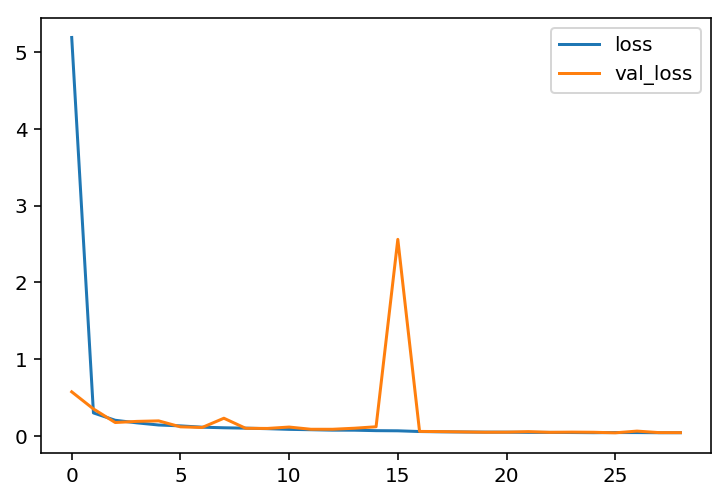

In [ ]:
import pandas as pd

df = pd.read_csv('cnn.csv')
df[['loss', 'val_loss']].plot()

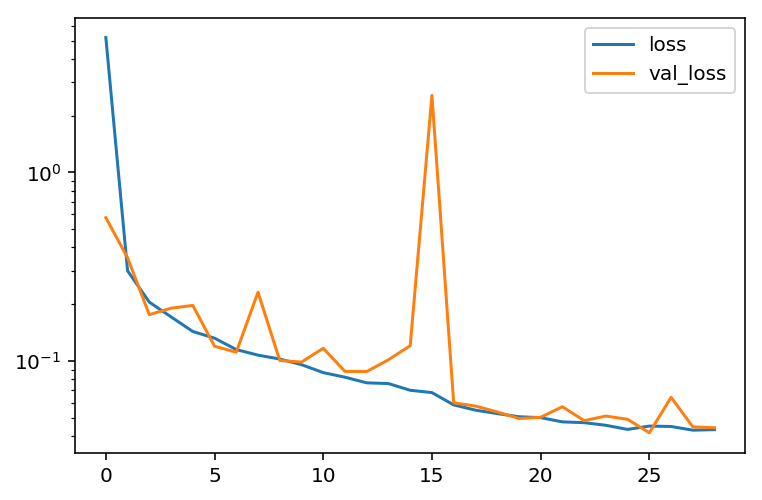

In [ ]:
df[['loss', 'val_loss']].plot(logy=True)